In [1]:
#reconstruction of the covariance matrix for the 100 detector experiment
import numpy as np
from scipy.io import mmread
#---------------------------------------------------------
#changing the columns order
def hhvv_column_order(M):
    nd = M.shape[1]
    vindex = np.arange(nd)
    nindex = (np.reshape(vindex,(-1,2))).T.flatten()
    return M[:,nindex]
#---------------------------------------------------------
def hvhv_column_order(M):
    nd = M.shape[1]
    vindex = np.arange(nd)
    nindex = (np.reshape(vindex,(2,-1))).T.flatten()
    return M[:,nindex]

In [2]:
#reading the transfer matrix 
um = mmread('./t_matrix.mtx')
tm = hhvv_column_order(um) #changing column order
n_det, n_st = tm.shape[0], tm.shape[1]

In [3]:
#reading the squeezing parameters
sq_par = np.loadtxt('./sq_par.txt')

In [4]:
#computing the covariance matrix for the experiment
tb = np.block([[tm,np.zeros((n_det,n_st))],[np.zeros((n_det,n_st)),tm.conjugate()]])
tbc = np.block([[tm.T.conjugate(),np.zeros((n_st,n_det))],[np.zeros((n_st,n_det)),tm.T]])
ds_ch = np.cosh(np.concatenate((sq_par,sq_par)))
ds_sh = np.sinh(np.concatenate((sq_par,sq_par)))
sm_csh = hvhv_column_order(np.array([ds_ch,ds_sh]))
sm = np.block([[np.diag(sm_csh[0]),np.diag(sm_csh[1])],[np.diag(sm_csh[1]),np.diag(sm_csh[0])]]) 
cov_final_complex_husimi = np.identity(2*n_det) - (1/2)*(tb@tbc) + (1/2)*(tb@(sm@sm)@tbc) #Complex Husimi covariance matrix
cov_final_complex_wigner = cov_final_complex_husimi - 0.5*np.identity(len(cov_final_complex_husimi)) #Complex Wigner covariance matrix

In [5]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats=['svg']
np.set_printoptions(linewidth=200)
#---------------------------------------------------------
from thewalrus.quantum import is_valid_cov, is_pure_cov, is_classical_cov
from thewalrus.quantum import reduced_gaussian
from thewalrus._torontonian import threshold_detection_prob
from thewalrus.symplectic import passive_transformation
#---------------------------------------------------------
#transformation matrix between the xp and aa* representations
def rmat(l, hbar=1):
    """
    This is the R matrix in https://the-walrus.readthedocs.io/en/latest/gbs.html
    """
    idl = np.identity(l)/np.sqrt(2*hbar)
    return np.block([[idl, 1j*idl],[idl, -1j*idl]])

In [6]:
#transformation of the covariance matrix to the xp representation (the former was in the aa* representation)
num_modes = len(cov_final_complex_wigner)//2
Rmat = rmat(num_modes)
cov_final_xp_wigner = np.real_if_close(Rmat.T.conj() @ cov_final_complex_wigner @ Rmat)
eigval_cov_xp_wigner = np.linalg.eigvalsh(cov_final_xp_wigner) #eigenvalues of the covariance matrix

In [7]:
#checking if the covariance matrix is valid (if it fulfills the uncertainty principle)
is_valid_cov(cov_final_xp_wigner, hbar=1)

True

In [8]:
#checking if the covariance matrix corresponds to a pure state
is_pure_cov(cov_final_xp_wigner, hbar=1)

False

In [9]:
#checking if the covariance matrix corresponds to a classical state
is_classical_cov(cov_final_xp_wigner, hbar=1)

False

In [10]:
#computation of single count probabilities in each mode
mode = 0
probs = np.empty([num_modes])
for mode in range(num_modes):
    mu_mode, cov_mode = reduced_gaussian(np.zeros(len(cov_final_xp_wigner)), cov_final_xp_wigner, [mode])
    probs[mode] = threshold_detection_prob(mu_mode, cov_mode, [1], hbar=1).real
#probabilities calculated from the experimental samples (10^5 samples)
exp_probs = np.flip(np.loadtxt('./exp_prob.txt'))

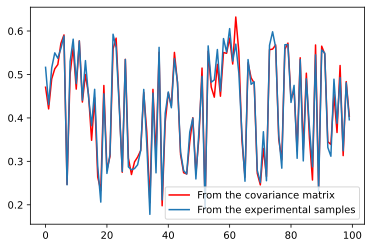

In [11]:
plt.plot(probs, label = "From the covariance matrix", color = "red")
plt.plot(exp_probs, label = "From the experimental samples")
plt.legend()

In [12]:
#count probabilities in two adjacent modes
mode_pair = 0
double_probs = np.empty([num_modes//2])
for mode_pair in range(num_modes//2):
    mu_mode, cov_mode = reduced_gaussian(np.zeros(len(cov_final_xp_wigner)), cov_final_xp_wigner, [2*mode_pair,2*mode_pair+1])
    double_probs[mode_pair] = threshold_detection_prob(mu_mode, cov_mode, [1,1], hbar=1).real
#double probabilities calculated from the experimental samples (10^5 samples)  
exp_double_probs = np.flip(np.loadtxt('./exp_double_prob.txt'))

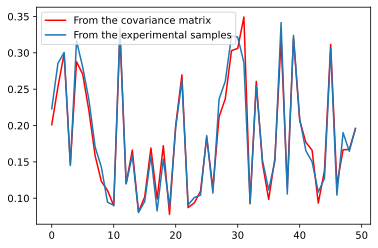

In [13]:
plt.plot(double_probs, label = "From the covariance matrix", color = "red")
plt.plot(exp_double_probs, label = "From the experimental samples")
plt.legend()